In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(".")

In [2]:
from functools import partial
import itertools as it
from typing import Callable

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import lenses
import optax

In [3]:
from jaxtyping import install_import_hook, jaxtyped
from beartype import beartype

with install_import_hook("so3os", ("beartype", "beartype")):
    from so3os import euler, geometry, quaternion, moebius
    from so3os.func_utils import compose, composed, unpack_args
    from so3os.jax_utils import key_chain
    from so3os.bijector import accumulate_volume, conditional_bijector, invert
    from so3os.bijector_impl import affine_transform, double_moebius_transform
    from so3os.nn import dense, residual

/home/jonas/miniconda3/envs/dev/lib/python3.10/site-packages/beartype/_util/hint/pep/utilpeptest.py:345: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Tuple[jaxtyping.Float[Array, '4'], jaxtyping.Float[Array, '3'], jaxtyping.Float[Array, ''], jaxtyping.Float[Array, ''], jaxtyping.Float[Array, '']] deprecated by PEP 585 scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". See this discussion for further details and alternatives:
    https://github.com/beartype/beartype#pep-585-deprecations
  warn(


In [4]:
from so3os.array_types import VectorN


@jaxtyped
@beartype
class AntipodalNet(eqx.Module):
    
    encoder: eqx.Module
    decoder: eqx.Module
    
    def __call__(
        self,
        q: quaternion.Quaternion,
        key: jax.random.PRNGKeyArray | jnp.ndarray | None
    ) -> VectorN:
        v0 = q
        v1 = -q
        
        ypos = self.encoder(v0)
        yneg = self.encoder(v1)
        
        y = jnp.stack([ypos, yneg], axis=0)
        y_ = jax.nn.softmax(y, axis=0)

        z = (y_ * y).sum(0)
        
        return self.decoder(z)

In [5]:
num_aux = 4
dim = 4

In [6]:
seed = jax.random.PRNGKey(42)
chain = key_chain(seed)

In [11]:
@jaxtyped
class Node(eqx.Module):
    quat: quaternion.Quaternion
    aux: geometry.VectorN

In [8]:
def quat_to_aux_coupling():
    return conditional_bijector(
        transform=affine_transform,
        context=lenses.lens.quat,
        target=lenses.lens.aux,
        params=eqx.nn.Sequential([
            AntipodalNet(
                eqx.nn.Sequential(tuple(dense(next(chain), [dim, 256, 256], residual(jax.nn.silu)))),
                eqx.nn.Sequential(tuple(dense(next(chain), [256, 256, 2 * num_aux], residual(jax.nn.silu))))
            ),
            eqx.nn.Lambda(partial(jnp.split, indices_or_sections=[num_aux])),
        ]))



def aux_to_quat_coupling():
    return conditional_bijector(
        transform=double_moebius_transform,
        context=lenses.lens.aux,
        target=lenses.lens.quat,
        params=eqx.nn.Sequential([
            *dense(next(chain), [num_aux, 256, 256, dim], residual(jax.nn.silu)),
            eqx.nn.Lambda(lambda arg: arg / (1. + geometry.norm(arg)) * 0.99),
            eqx.nn.Lambda(lambda x: (x,))
        ]))


flow = compose(*map(accumulate_volume, (
    aux_to_quat_coupling(),
    quat_to_aux_coupling(),
    aux_to_quat_coupling(),
    quat_to_aux_coupling(),
)))

In [9]:

K = 2  # num clusters
std = 0.05  # cluster std
so3_only = True  # sample data only on SO(3) or on full S3?


def sample_mixture(key, means, stds):
    """ sample simple mixture model """
    chain = key_chain(key)
    samples = jax.random.normal(next(chain), shape=means.shape) * stds + means
    mixture = jax.random.choice(next(chain), jnp.arange(means.shape[0]))
    return samples[mixture]


def sample_target(key):
    """ sample target density on so(3) / s3 """
    chain = key_chain(key)
    angles = jnp.concatenate([
        sample_mixture(next(chain), jnp.linspace(0., 1., K, endpoint=False).reshape(-1, 1), std * jnp.ones(K).reshape(-1, 1)) *2 * jnp.pi,
        jnp.arccos(
            jnp.clip(sample_mixture(next(chain), jnp.linspace(-0.6, 0.6, K).reshape(-1, 1), std * jnp.ones(K).reshape(-1, 1)), -1., 1.)
        ),
        sample_mixture(next(chain), jnp.linspace(0., 1., K, endpoint=False).reshape(-1, 1), std * jnp.ones(K).reshape(-1, 1)) * 2* jnp.pi
    ])
    q = quaternion.mat_to_quat(euler.from_euler(angles))
    if not so3_only:
        q = q * jnp.where(jax.random.normal(next(chain), (1,)) > 0, 1., -1.)
    aux = jax.random.normal(next(chain), shape=(num_aux,))
    return Node(q, aux)


def sample_uniform(key):
    """ uniform samples on so(3) / s3 """
    chain = key_chain(key)
    quat = geometry.unit(jax.random.normal(next(chain), shape=(dim,)))    
    aux = jax.random.normal(next(chain), shape=(num_aux,))
    return Node(quat, aux)


def sample_flow(flow, key):
    """ sample flow density """
    chain = key_chain(key)
    y, _ = invert(flow)((sample_uniform(key), jnp.array(0.)))
    return y

In [10]:
# test flow inverses

a = sample_uniform(next(chain))
b, vol_b = flow((a, jnp.array(0.)))
c, vol_c = invert(flow)((b, jnp.array(0.)))
assert jnp.allclose(a.quat, c.quat)
assert jnp.allclose(a.aux, c.aux)
assert jnp.allclose(vol_b, -vol_c, atol=1e-5)

BeartypeCallHintParamViolation: @beartyped __main__.Node.__init__() parameter aux="DeviceArray([ 0.26629442, -4.3684754 , -4.0736527 , -0.2164526 ], dtype=float32)" violates type hint <class 'jaxtyping.Float[Array, 'N']'>, as <protocol "jaxlib.xla_extension.DeviceArray"> "DeviceArray([ 0.26629442, -4.3684754 , -4.0736527 , -0.2164526 ], dtype=float32)" not instance of <class "jaxtyping.Float[Array, 'N']">.

In [ ]:
def plot_flow(key: jax.random.PRNGKeyArray, flow: eqx.Module, log_norm: bool = False, savefile: str | None = None):

    if log_norm:
        norm = LogNorm()
    else:
        norm = None
        
    chain = key_chain(key)
        
    N = int(1/2 * (dim-1) * (dim ))
    
    target_samples = jax.jit(jax.vmap(sample_target))(jax.random.split(next(chain), 10000))
    flow_samples = jax.jit(jax.vmap(partial(sample_flow, flow)))(jax.random.split(next(chain), 10000))

    plt.figure(figsize=(8, 4 * N))
    for k, ((i, j)) in enumerate(it.combinations(range(dim), r=2), start=1):

        ax = plt.subplot(N, 2, 2 * k - 1)

        plt.title(f"data: {i},{j}")
        plt.hist2d(*target_samples.quat[:, (i, j)].T, bins=50, norm=norm, range=((-1.05, 1.05), (-1.05, 1.05)))
        ax.set_facecolor('xkcd:salmon')

        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

        ax = plt.subplot(N, 2, 2 * k)
        plt.title(f"flow: {i},{j}")
        plt.hist2d(*flow_samples.quat[:, (i, j)].T, bins=50, norm=norm, range=((-1.05, 1.05), (-1.05, 1.05)))
        ax.set_facecolor('xkcd:salmon')

        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

    if savefile is not None:
        plt.savefig(savefile)

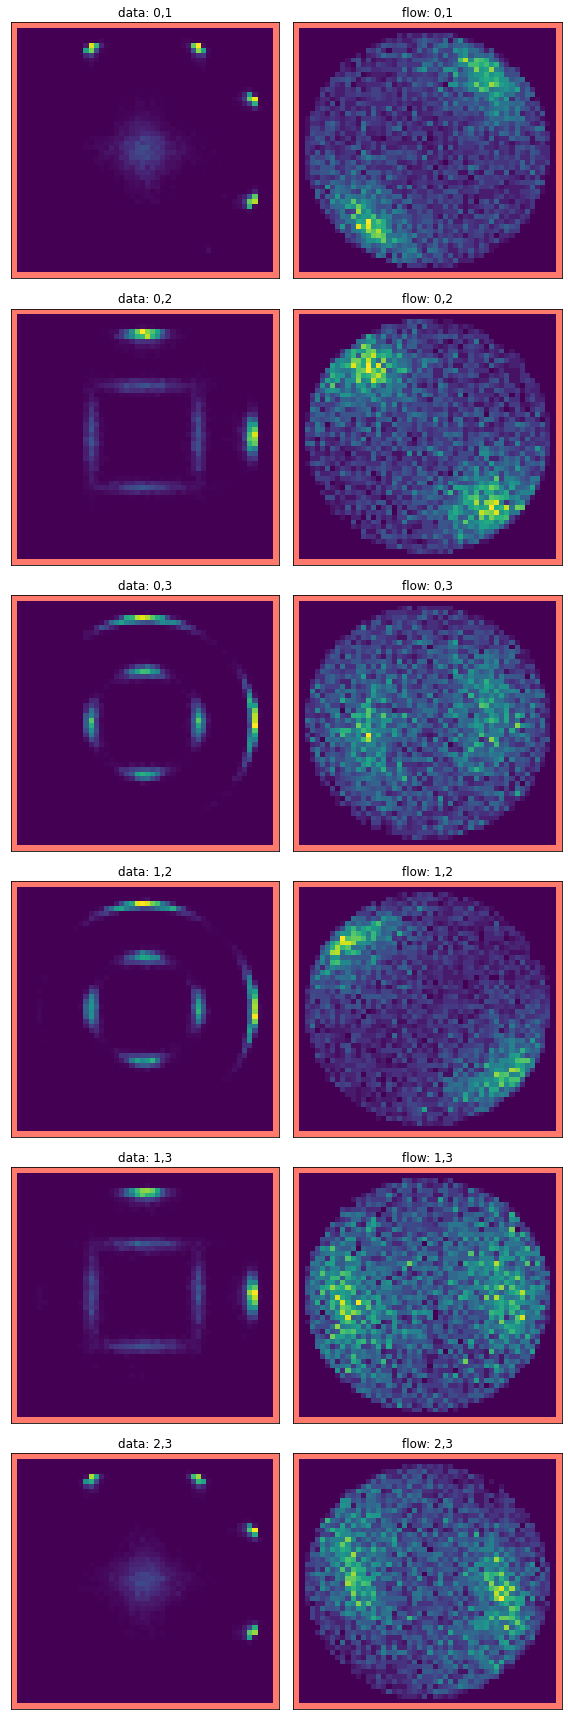

In [13]:
plot_flow(next(chain), flow)

In [14]:
@eqx.filter_value_and_grad
def loss_fn(flow, key):
    chain = key_chain(key)
    key = jax.random.split(key, 128)
    inp = jax.vmap(sample_target)(key)
    out, vol = jax.vmap(flow, in_axes=((0, None),))((inp, jnp.array(0.)))
    return (
        0.5 * jnp.square(out.aux).sum(axis=-1) 
        - vol
    ).mean()


@eqx.filter_jit
def step(flow, key, opt_state):
    loss, grads = loss_fn(flow, key)
    updates, opt_state = optim.update(grads, opt_state)
    return loss, eqx.apply_updates(flow, updates), opt_state

In [15]:
learning_rate = 5e-4
optim = optax.adam(learning_rate)
params, static = eqx.partition(flow, eqx.is_array)
opt_state = optim.init(params)

In [16]:
num_iters = 10_000
print_period = 1_000

for i in range(num_iters):
    loss, flow, opt_state = step(flow, next(chain), opt_state)
    if not i % print_period:
        print(f"iter: {i}/{num_iters}: nll: {loss:.4}")

iter: 0/10000: nll: 29.44
iter: 1000/10000: nll: 0.7455
iter: 2000/10000: nll: 0.6454
iter: 3000/10000: nll: 0.5938
iter: 4000/10000: nll: 0.2332
iter: 5000/10000: nll: 0.6267
iter: 6000/10000: nll: 0.636
iter: 7000/10000: nll: 0.4529
iter: 8000/10000: nll: 0.0713
iter: 9000/10000: nll: 0.287


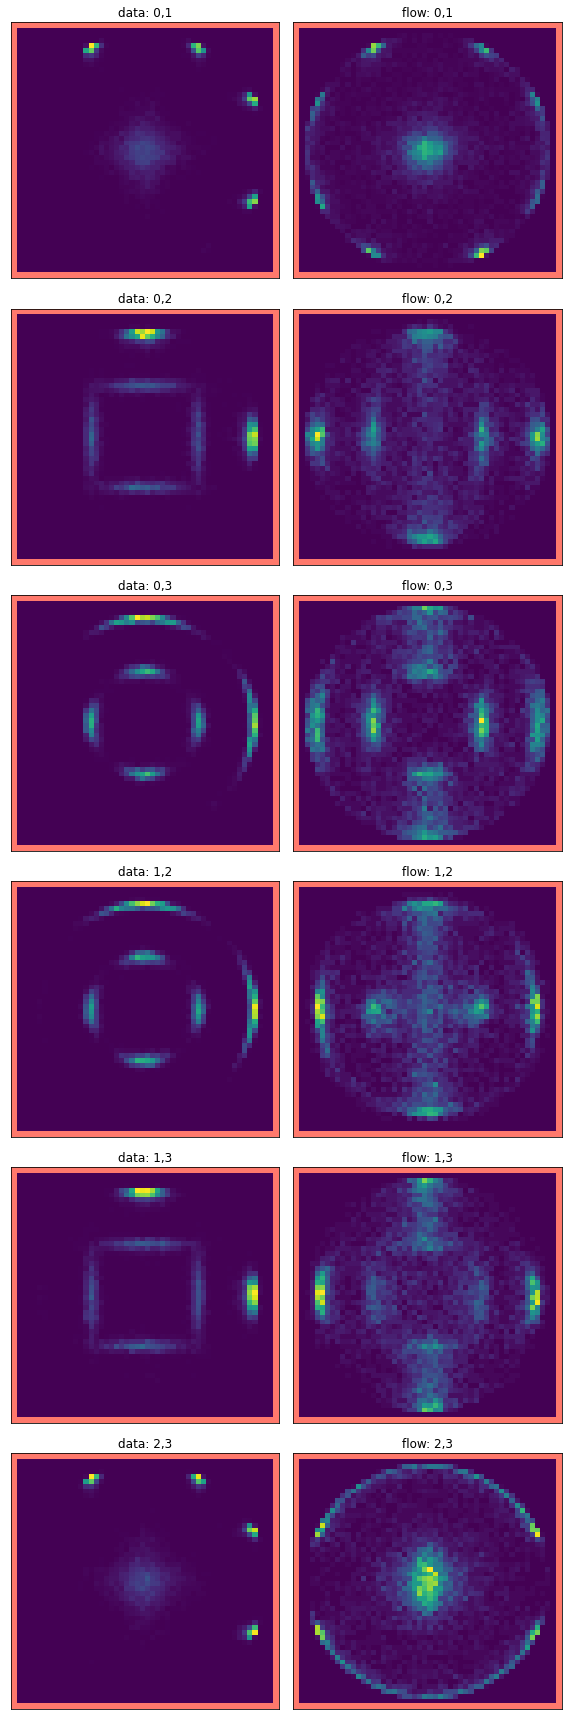

In [17]:
plot_flow(next(chain), flow)